Time Series


## <font color = "Blue"> Packages </font>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import scipy.stats as ss
import seaborn as sns
#import statsmodels.api as sm

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

from datetime import datetime

from statsmodels.formula.api import ols
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from scipy.stats import mstats
from sklearn.model_selection import train_test_split

In [0]:
!pip install scikit_posthocs
import scikit_posthocs as sp

Now we can use any of the non-parametric post-hoc tests, and

In [0]:
!pip install pmdarima
from pmdarima.arima import auto_arima

which allow us to use the `auto_arima` function to select from the AIC the best SARIMA model

---
## The Data

For this case, we will need two different datasets:

 * The first contains the *monthly* series fo the inflation rate (IR) of Spain from 2002 to 2019
 * The second contains the *quarterly* series for the inflation rate and the unemployment rate (UR) of Spain from 2002 to 2019
 
The second set is the consistent dataset for both variables so that we can use it later to build a model

In [0]:
# @hidden_cell
from IPython.display import HTML
HTML('<table style="margin-left:auto;margin-right:auto;"><caption style = "text-align: center;">Table 1.- Monthly series</caption><tr><th>Variable</th><th style="text-align: center;">Description</th></tr><tr><td>mIR</td><td> Inflation Rate 2002-2019</td></tr></table><br><table style="margin-left:auto;margin-right:auto;"><caption style = "text-align: center;">Table 2.- Quarterly series</caption><tr><th>Variable</th><th style="text-align: center;">Description</th></tr><tr><td>qIR</td><td> Inflation Rate 2002-2019</td></tr><tr><td>qUR</td><td> Unemployement Rate 2002-2019</td></tr></table>')

Variable,Description
mIR,Inflation Rate 2002-2019
Variable,Description
qIR,Inflation Rate 2002-2019
qUR,Unemployement Rate 2002-2019


In order to have two proper datasets, use the following codes. For the **Monthly** dataset

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
dateparse = lambda dates : pd.datetime.strptime(dates, '%Y-%m')
monthly = pd.read_csv('/content/drive/My Drive/Monthly.csv', 
                     parse_dates=['Month'],
                     index_col='Month',
                     date_parser=dateparse)
monthly = monthly.drop('Unnamed: 0', axis = 1)
monthly.head()

,mIR
Month,
2002-01-01,-0.0014
2002-02-01,0.0009
2002-03-01,0.0083
2002-04-01,0.0136
2002-05-01,0.0036


And for the **Quarterly** dataset

In [0]:
quarterly = pd.read_csv('/content/drive/My Drive/Quarterly.csv')
quarterly = quarterly.drop('Unnamed: 0', axis = 1)

quarterly = quarterly.set_index(['Year', 'Quarter'])
quarterly = quarterly.sort_values(by=['Year', 'Quarter'])
quarterly = quarterly.reset_index(level=[0,1])
quarterly['Month'] = (quarterly['Year'].astype(str) + '-' + (quarterly['Quarter']*3).astype(str)).apply(dateparse)
quarterly = quarterly.set_index('Month')

quarterly.head()

,Year,Quarter,qUR,qIR
Month,,,,
2002-03-01,2002,1,0.1155,0.0026
2002-06-01,2002,2,0.1115,0.0058
2002-09-01,2002,3,0.1149,-0.0001
2002-12-01,2002,4,0.1161,0.0049
2003-03-01,2003,1,0.1199,0.0016


---
# <font color = "Blue"> Case Study </font>

In this case we are going to analyse the relation between the **Unemployment Rate** and the **Inflation Rate** in terms of the so-called **Phillips Curve**. For this we will consider the modern version of this equation which makes use of the current expectations for the inflation (directly written as the inflation at $t-1$).

\begin{equation}
\text{inflation}_t = \beta_0 + \beta_1\text{inflation}_{t-1} + \beta_2\text{unemployment}_t + u_t
\end{equation}

We will do it using the previous dataset for Spain and for it we are going to do different analysis:

 * An individual study of the variables to see if there is a significant difference in the average values at different periods (ANOVA)
 * An SARIMA model for the inflation using unemployment as exogenous variable

## <font color = "MediumBlue">Functions</font>

In [0]:
# @hidden_cell
def NormalityTests(x, sig_level):
    '''
    This function computes the p-value and statistics of the Shapiro-Wilk and D'Agostino tests for normality
    It also includes the set of libraries to be loaded in the test (no cheks done)
    
    Inputs:
    
     - x: array of values of the variable to be tested
     - sig_level: significance level to be used in the decision of the test
    
    Output
    
     - p-value, statistic and decision for both tests    
    '''
    from scipy.stats import shapiro
    from scipy.stats import normaltest
    
    shap_stat, shap_p = shapiro(x)
    k2_stat, k2_p = normaltest(x)
    
    print("From the Shapiro Wilk test:\n\nStatistic: ", shap_stat, "\np-value: ", shap_p)
    if shap_p > sig_level:
        print("Fail to reject Normality: No evidence found against normality\n\n")
    else:
        print("Reject Normality: Evidence found against normality\n\n")
    
    print("From the D'Agostino test:\n\nStatistic: ", k2_stat, "\np-value: ", k2_p)
    if k2_p > sig_level:
        print("Fail to reject Normality: No evidence found against normality\n\n")
    else:
        print("Reject Normality: Evidence found against normality\n\n")
             


## <font color = "MediumBlue"> Monthly Series </font>

In this section we want to analyze if there is a significant difference in the inflation rate in different years using only the **monthly series**. For it do the following:

In [0]:
monthly.head()

,mIR
Month,
2002-01-01,-0.0014
2002-02-01,0.0009
2002-03-01,0.0083
2002-04-01,0.0136
2002-05-01,0.0036


In [0]:
monthly['Year'] = monthly.index.map(lambda x: x.strftime('%Y'))
monthly.groupby('Year')['mIR']

In [0]:
monthly.describe()

,mIR
count,207.000000
mean,0.001604
std,0.005983
min,-0.019100
25%,-0.001300
50%,0.001800
75%,0.005450
max,0.014400


In [0]:
ss.levene(monthly['mIR'][monthly['Year'] == '2002'].dropna(),
          monthly['mIR'][monthly['Year'] == '2003'].dropna(),
          monthly['mIR'][monthly['Year'] == '2004'].dropna(),
          monthly['mIR'][monthly['Year'] == '2005'].dropna(),
          monthly['mIR'][monthly['Year'] == '2006'].dropna(),
          monthly['mIR'][monthly['Year'] == '2007'].dropna(),
          monthly['mIR'][monthly['Year'] == '2008'].dropna(),
          monthly['mIR'][monthly['Year'] == '2009'].dropna(),
          monthly['mIR'][monthly['Year'] == '2010'].dropna(),
          monthly['mIR'][monthly['Year'] == '2011'].dropna(),
          monthly['mIR'][monthly['Year'] == '2012'].dropna(),
          monthly['mIR'][monthly['Year'] == '2013'].dropna(),
          monthly['mIR'][monthly['Year'] == '2014'].dropna(),
          monthly['mIR'][monthly['Year'] == '2015'].dropna(),
          monthly['mIR'][monthly['Year'] == '2016'].dropna(),
          monthly['mIR'][monthly['Year'] == '2017'].dropna(),
          monthly['mIR'][monthly['Year'] == '2018'].dropna(),
          monthly['mIR'][monthly['Year'] == '2019'].dropna())

LeveneResult(statistic=0.38136924787755433, pvalue=0.9879071564785713)

In [0]:
ss.bartlett(monthly['mIR'][monthly['Year'] == '2002'].dropna(),
          monthly['mIR'][monthly['Year'] == '2003'].dropna(),
          monthly['mIR'][monthly['Year'] == '2004'].dropna(),
          monthly['mIR'][monthly['Year'] == '2005'].dropna(),
          monthly['mIR'][monthly['Year'] == '2006'].dropna(),
          monthly['mIR'][monthly['Year'] == '2007'].dropna(),
          monthly['mIR'][monthly['Year'] == '2008'].dropna(),
          monthly['mIR'][monthly['Year'] == '2009'].dropna(),
          monthly['mIR'][monthly['Year'] == '2010'].dropna(),
          monthly['mIR'][monthly['Year'] == '2011'].dropna(),
          monthly['mIR'][monthly['Year'] == '2012'].dropna(),
          monthly['mIR'][monthly['Year'] == '2013'].dropna(),
          monthly['mIR'][monthly['Year'] == '2014'].dropna(),
          monthly['mIR'][monthly['Year'] == '2015'].dropna(),
          monthly['mIR'][monthly['Year'] == '2016'].dropna(),
          monthly['mIR'][monthly['Year'] == '2017'].dropna(),
          monthly['mIR'][monthly['Year'] == '2018'].dropna(),
          monthly['mIR'][monthly['Year'] == '2019'].dropna())

BartlettResult(statistic=8.72958981698933, pvalue=0.948364981365092)

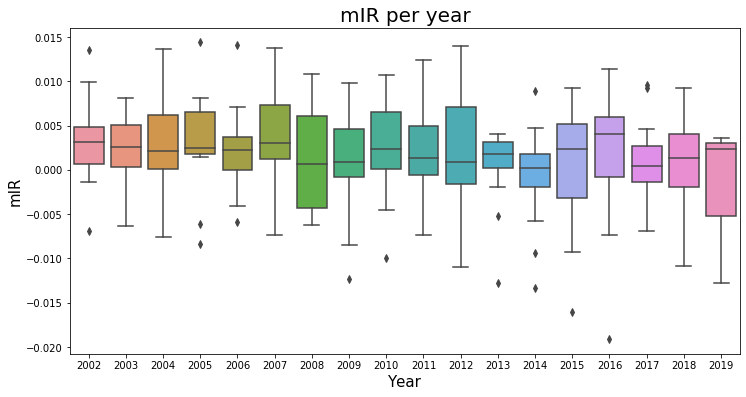

In [0]:
plt.figure(figsize = (12,6))
g = sns.boxplot(data = monthly, x = 'Year', y = 'mIR')
g.axes.set_title('mIR per year', fontsize = 20)
g.axes.set_xlabel('Year', fontsize = 15)
g.axes.set_ylabel('mIR', fontsize = 15)
plt.show()

In [0]:
NormalityTests(monthly['mIR'], 0.01)

From the Shapiro Wilk test:

Statistic:  0.9774258136749268 
p-value:  0.0020670932717621326
Reject Normality: Evidence found against normality


From the D'Agostino test:

Statistic:  10.163703554217589 
p-value:  0.006208401788506506
Reject Normality: Evidence found against normality




In [0]:
print("Kruskal Wallis H-test test:\n")

H, pval = mstats.kruskalwallis(
          monthly['mIR'][monthly['Year'] == '2002'].dropna().values,
          monthly['mIR'][monthly['Year'] == '2003'].dropna().values,
          monthly['mIR'][monthly['Year'] == '2004'].dropna().values,
          monthly['mIR'][monthly['Year'] == '2005'].dropna().values,
          monthly['mIR'][monthly['Year'] == '2006'].dropna().values,
          monthly['mIR'][monthly['Year'] == '2007'].dropna().values,
          monthly['mIR'][monthly['Year'] == '2008'].dropna().values,
          monthly['mIR'][monthly['Year'] == '2009'].dropna().values,
          monthly['mIR'][monthly['Year'] == '2010'].dropna().values,
          monthly['mIR'][monthly['Year'] == '2011'].dropna().values,
          monthly['mIR'][monthly['Year'] == '2012'].dropna().values,
          monthly['mIR'][monthly['Year'] == '2013'].dropna().values,
          monthly['mIR'][monthly['Year'] == '2014'].dropna().values,
          monthly['mIR'][monthly['Year'] == '2015'].dropna().values,
          monthly['mIR'][monthly['Year'] == '2016'].dropna().values,
          monthly['mIR'][monthly['Year'] == '2017'].dropna().values,
          monthly['mIR'][monthly['Year'] == '2018'].dropna().values,
          monthly['mIR'][monthly['Year'] == '2019'].dropna().values)

print("H-statistic:", H)
print("P-Value:", pval)

if pval < 0.05:
    print("\nReject the NULL hypothesis for a 5%: There is evidence in favor of significant differences between the inflation rates in given years.")
if pval > 0.05:
    print("\nFail to Reject the NULL hypothesis for a 5%: There is no evidence in favor of significant differences between the inflation rates in given years")

Kruskal Wallis H-test test:

H-statistic: 8.144032849423231
P-Value: 0.9633691499154529

Fail to Reject the NULL hypothesis for a 5%: There is no evidence in favor of significant differences between the inflation rates in given years


 
#### <font color = "MediumBlue">  Interpretation </font>

* From the boxplots we can see that the data is distributed quite differently for each year. Half of the boxplots have similar sizes which means that only in those years interquartile ranges are the same. Medians are also located on different levels but not so critically inconsistent.
* Both levene and bartlett tests result with a p-value higher than the significance level that was chosen (and also any common SL). That is why  we fail to reject the Null hypothesis and must conclude that we do not find evidence against the equality of variances in inflation rate 2002-2019. 
* After finding out that Normality test resulted with a p-value lower than common SL, we reject Null hypothesis, which is that data normally distributed.
* That's why we perform non-parametric Kruskal-Wallis test for checking if there is any evidence in favor of significant differences between the inflation rates in given years, which returned high enough p-value to fail to reject H0.
* In my opinion, those tests are ok, but could be more efficient to test e.g distributions in terms of Crisis and not crisis year only instead of packing all the years into test. I did such test, comparing 2008 with couple of other years, but results were the same - no significance difference. Even that boxplots don't say exactly the same as tests, I conclude that there is no big difference in variances of inflation rate through the years 2002-2019.

---

## <font color = "MediumBlue"> Time Series Analysis </font>

From now on we will only work with the **quarterly series**. Then


#### <font color = "MediumBlue"> EDA </font>

Let's perform an **EDA** analysis of both, `qIR` and `qUR` consisting on

 * **Plot** the series together with its moving averages and standard deviations. **Explain** if the scheme is additive or multiplicative. 
 * Perform a **model decomposition** (you must choose the periodicity)
 * Perform a **test** to determine if the series are stationary (you must choose a significance level)

In [0]:
m_aver_qur = quarterly['qUR'].rolling(4).mean()
std_aver_qur = quarterly['qUR'].rolling(4).std()

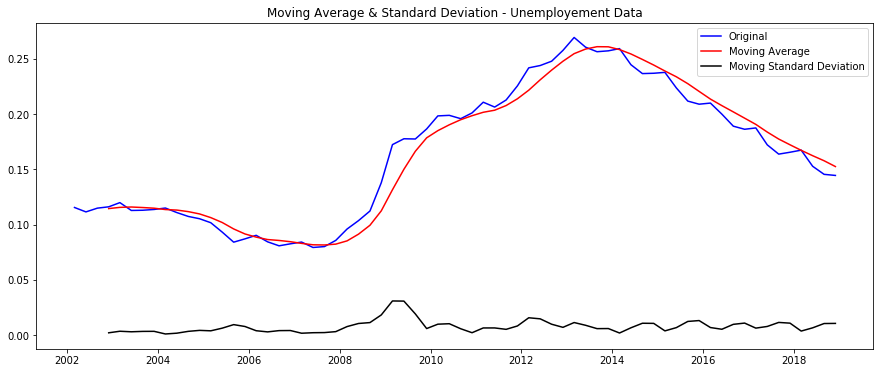

In [0]:
orig = plt.plot(quarterly['qUR'], color='blue',label='Original')
mean = plt.plot(m_aver_qur, color='red', label='Moving Average')
std = plt.plot(std_aver_qur, color='black', label = 'Moving Standard Deviation')
plt.legend(loc='best')
plt.title('Moving Average & Standard Deviation - Unemployement Data')
plt.show(block=False)

In [0]:
m_aver_qir = quarterly['qIR'].rolling(4).mean()
std_aver_qir = quarterly['qIR'].rolling(4).std()

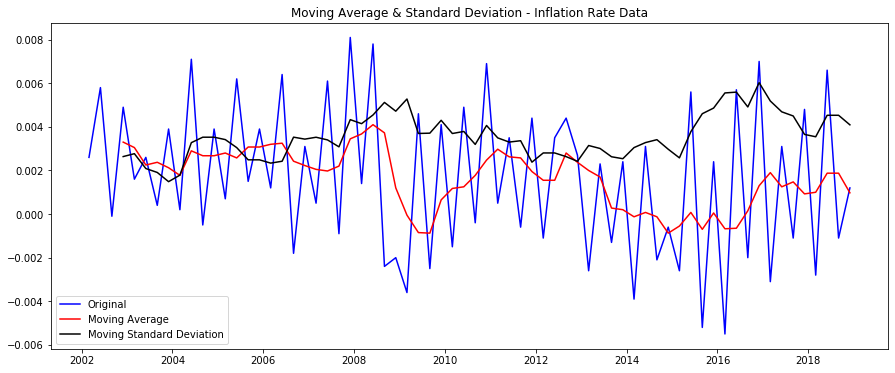

In [0]:
orig = plt.plot(quarterly['qIR'], color='blue',label='Original')
mean = plt.plot(m_aver_qir, color='red', label='Moving Average')
std = plt.plot(std_aver_qir, color='black', label = 'Moving Standard Deviation')
plt.legend(loc='best')
plt.title('Moving Average & Standard Deviation - Inflation Rate Data')
plt.show(block=False)

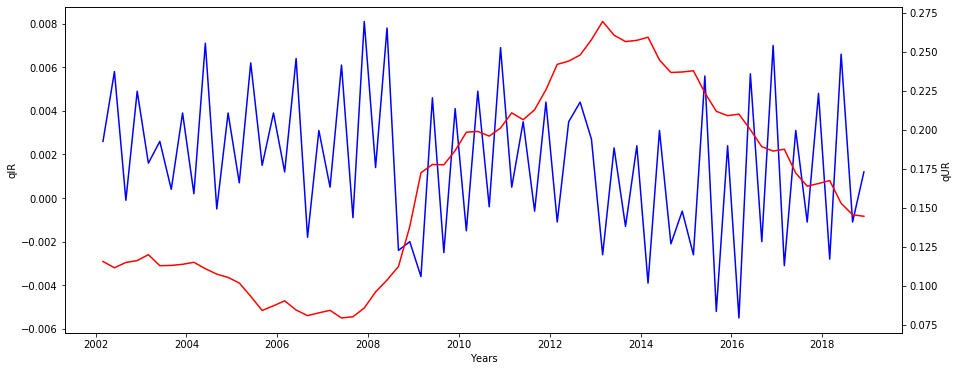

In [0]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.plot(quarterly.qIR, color = 'blue', label = 'qIR')
ax2.plot(quarterly.qUR, color = 'red', label = 'qUR')

ax.set_xlabel('Years')
ax.set_ylabel('qIR')
ax2.set_ylabel('qUR')

plt.show(block=False)

**Interpretation**
* From the graphs of both inflation and unemployment rate we don't see any exponential growth tendency. Unemployment rate may have it between years 2008-2014 but in general it is quite smooth.
* The inflation rate graph has a variability that is changing a lot.
* When lloking at the plot with both variables at the same time, we don't see that those behave very similar. There is some positive correlation only at some points e.g growth of inflation rate is a bit accompanied by growth of the unemployment rate in years 2008-2011. 

In [0]:
decomposition_qir = seasonal_decompose(quarterly['qIR'])

In [0]:
trend_qir = decomposition_qir.trend
seasonal_qir = decomposition_qir.seasonal
residual_qir = decomposition_qir.resid

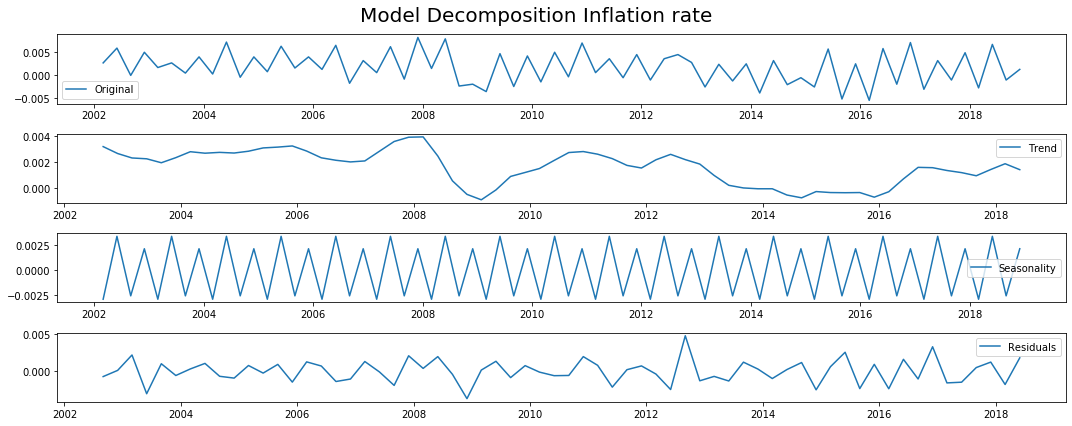

In [0]:
plt.suptitle('Model Decomposition Inflation rate', fontsize = 20)

plt.subplot(411)
plt.plot(quarterly['qIR'], label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend_qir, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal_qir,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual_qir, label='Residuals')
plt.legend(loc='best')

plt.tight_layout(rect = (0,0,1,0.94))
plt.show()

In [0]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(quarterly['qIR'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -2.228826
p-value                         0.195950
Number of Lags Used             5.000000
Number of Observations Used    62.000000
Critical Value (1%)            -3.540523
Critical Value (5%)            -2.909427
Critical Value (10%)           -2.592314
dtype: float64


In [0]:
decomposition_qur = seasonal_decompose(quarterly['qUR'])
trend_qur = decomposition_qur.trend
seasonal_qur = decomposition_qur.seasonal
residual_qur = decomposition_qur.resid

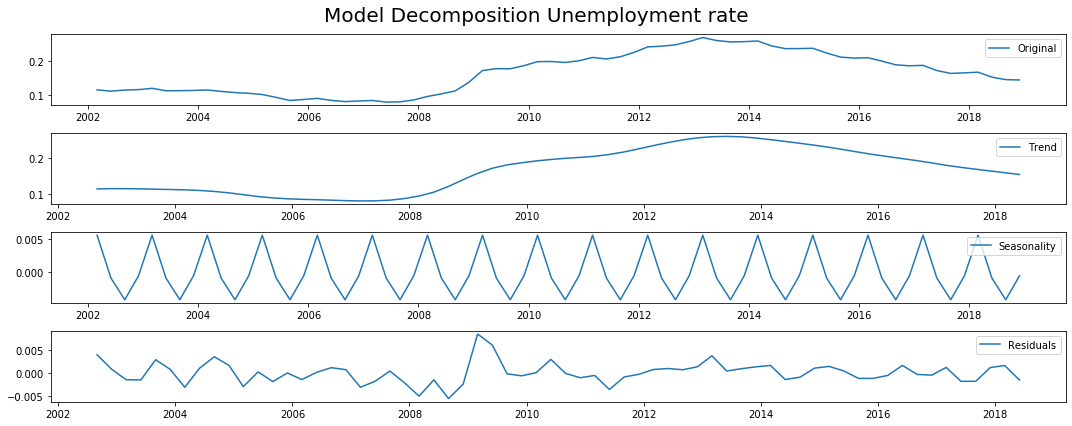

In [0]:
plt.suptitle('Model Decomposition Unemployment rate', fontsize = 20)

plt.subplot(411)
plt.plot(quarterly['qUR'], label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend_qur, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal_qur,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual_qur, label='Residuals')
plt.legend(loc='best')

plt.tight_layout(rect = (0,0,1,0.94))
plt.show()

In [0]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(quarterly['qUR'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -2.238208
p-value                         0.192672
Number of Lags Used            11.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64


**Interpretation**
* Non-stationarity test for inflation rate resulted with the same high p-value 0.19 as for the unemployment rate, which is lower than significance level I've chosen (5%) and let us conclude that there are no evidences against non-stationarity and we fail to reject null hypothesis. 
* Doing same test for residuals, the result for inflation rate could let us reject H0 but i decide to stay with the metrics for whole series, not for the residuals.
* I expected more correlation in inflation and unemployment rate during all years we've been given. It is socially acceptable to think that growth of inflation leads to growth of unemployment rate. I don't see much proof of it on the graphs, which is quite interesting. 

#### <font color = "MediumBlue"> (S)ARIMA </font>




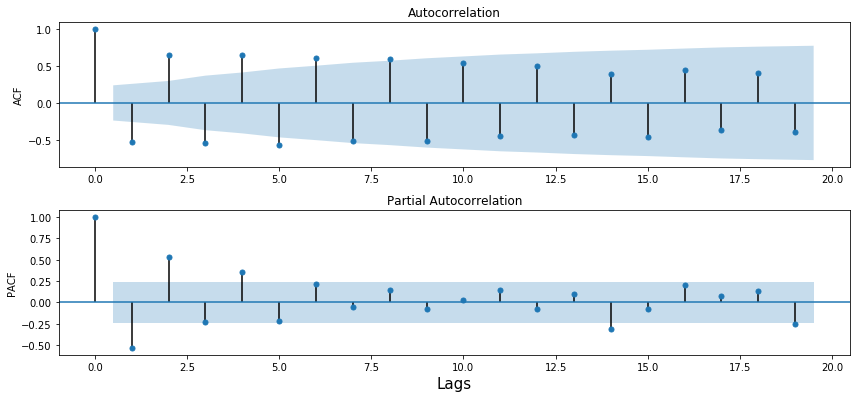

In [0]:
plt.figure(figsize = (12,6))
plt.subplot(211)
plot_acf(quarterly['qIR'], ax = plt.gca())
plt.ylabel('ACF')

plt.subplot(212)
plot_pacf(quarterly['qIR'], ax = plt.gca())
plt.ylabel('PACF')
plt.xlabel('Lags', fontsize = 15)

plt.tight_layout(rect = (0,0,1,0.94))
plt.show()

In [0]:
arima_001 = ARIMA(quarterly['qIR'], (0,0,1),exog = quarterly['qUR']).fit()
print(arima_001.summary())

                              ARMA Model Results                              
Dep. Variable:                    qIR   No. Observations:                   68
Model:                     ARMA(0, 1)   Log Likelihood                 300.517
Method:                       css-mle   S.D. of innovations              0.003
Date:                Sun, 26 Jan 2020   AIC                           -593.034
Time:                        18:39:49   BIC                           -584.156
Sample:                    03-01-2002   HQIC                          -589.517
                         - 12-01-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.001      6.157      0.000       0.003       0.005
qUR           -0.0136      0.004     -3.786      0.000      -0.021      -0.007
ma.L1.qIR     -0.3964      0.088     -4.501      0.0

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)


In [0]:
arima_100 = ARIMA(quarterly['qIR'], (1,0,0),exog = quarterly['qUR']).fit()
print(arima_100.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                    qIR   No. Observations:                   68
Model:                     ARMA(1, 0)   Log Likelihood                 308.088
Method:                       css-mle   S.D. of innovations              0.003
Date:                Sun, 26 Jan 2020   AIC                           -608.177
Time:                        18:39:49   BIC                           -599.299
Sample:                    03-01-2002   HQIC                          -604.659
                         - 12-01-2018                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.001      6.800      0.000       0.003       0.005
qUR           -0.0137      0.003     -4.188      0.000      -0.020      -0.007
ar.L1.qIR     -0.6111      0.094     -6.518      0.0

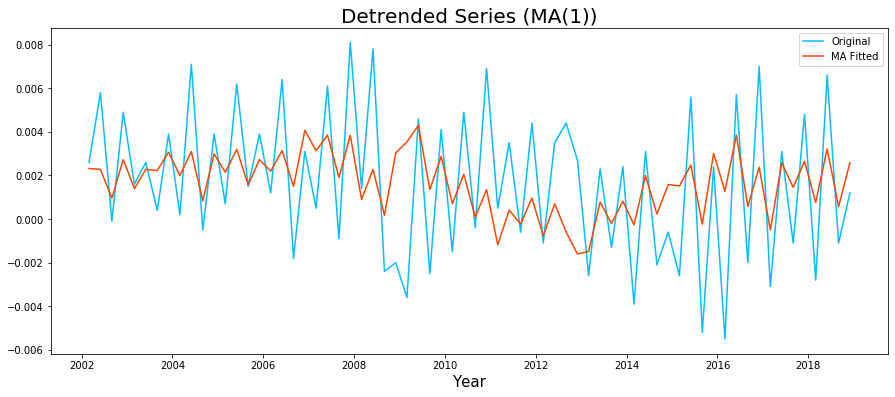

In [0]:

plt.plot(quarterly['qIR'], color = "DeepSkyBlue", label = 'Original')
plt.plot(arima_.fittedvalues, color='OrangeRed', label = 'MA Fitted')
plt.legend(loc = 'best')
plt.xlabel('Year', fontsize = 15)
plt.title('Detrended Series (MA(1))', fontsize = 20)
plt.show()

In [0]:
predictions_ARIMA_100 = arima_100.predict()
print(predictions_ARIMA.head())

2002-03-01    0.002319
2002-06-01    0.002277
2002-09-01    0.000960
2002-12-01    0.002730
2003-03-01    0.001399
Freq: QS-DEC, dtype: float64


In [0]:
# predictions_ARIMA = pd.Series(arima_.fittedvalues, copy=True)
predictions_ARIMA_001 = arima_001.predict()
print(predictions_ARIMA_001.head())

2002-03-01    0.002319
2002-06-01    0.002277
2002-09-01    0.000960
2002-12-01    0.002730
2003-03-01    0.001399
Freq: QS-DEC, dtype: float64


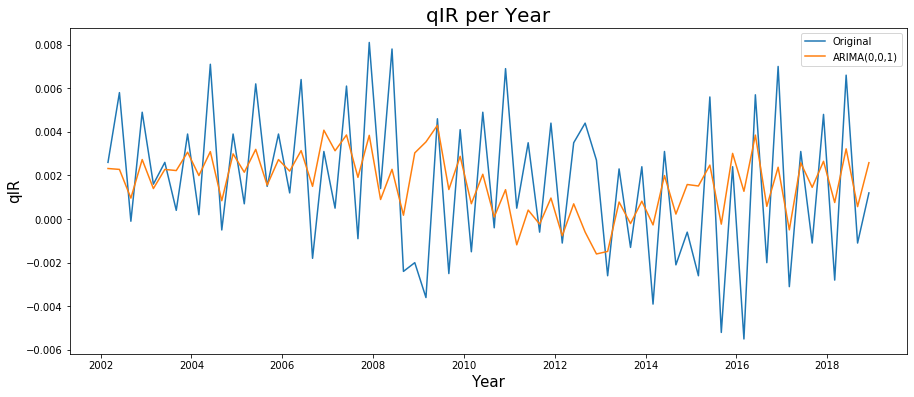

In [0]:
plt.plot(quarterly['qIR'], label = 'Original')
plt.plot(predictions_ARIMA, label = 'ARIMA(0,0,1)')

plt.xlabel('Year', fontsize = 15)
plt.ylabel('qIR', fontsize = 15)
plt.title('qIR per Year', fontsize = 20)
plt.legend(loc = 'best')

plt.show()

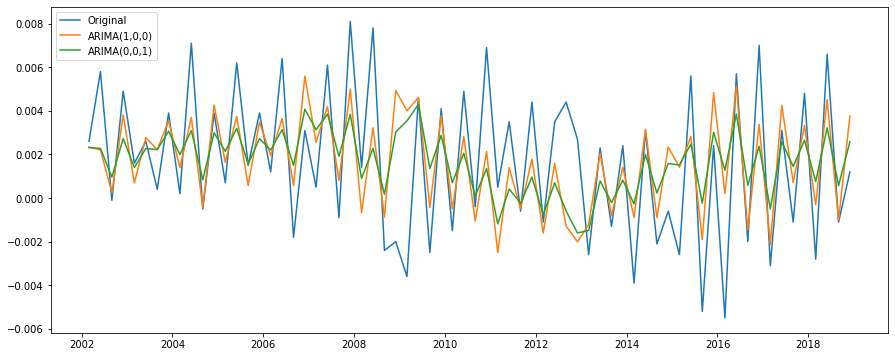

In [0]:
plt.plot(quarterly['qIR'], label = 'Original')
plt.plot(predictions_ARIMA_100, label = 'AR(1,0,0)')
plt.plot(predictions_ARIMA_001, label = 'MA(0,0,1)')

plt.legend(loc = 'best')
plt.show()

* Comparing AR(1) and MA(1) models on the graph, we can notice that AR(1) performs better and the predictions are pretty close to the real values, so AR component is dominating in this case.

* As we can see from results, the best model would be the second one (ARIMA_100). Though AIC for Arima_100 is a little bit lower than for the arima_001, which shows that actually first model is better. The summary attribute that results from the output of ARIMA returns a significant amount of information, but we’ll focus our attention on the table of coefficients. The coef column shows the weight of qUR feature and how it impacts the time series. The coefficient is only 0.0137, so we can't say that unemployment rate is significantly important for our model.
* Considering the equation that was presented to describe relation between inflation rate and unemployment rate:
\begin{equation}
\text{inflation}_t = \beta_0 + \beta_1\text{inflation}_{t-1} + \beta_2\text{unemployment}_t + u_t
\end{equation}

and taking into account results that we've received, equation of the model would be:

\begin{equation}
\text{inflation}_t = \text{inflation}_{t} + 0.9863\text{inflation}_{t-1} + 0.0137\text{unemployment}_{t-2}
\end{equation}

and for (p,d,q) --> (1,0,0)
